# 

title: Water Rights Restored to the Gila River

subtitle: The impacts of irrigation on vegetation health in the Gila
River Valley

author:

-   Elsa Culler

-   Nate Quarderer

date: last-modified

image: /img/earth-analytics/water-rights/lesson-water-rights.png

image-alt: “Dry river with dead plants turns into a stream with living
plants”

description: \|

In 2004, the Akimel O’‘otham and Tohono O’’odham tribes won a water
rights settlement in the US Supreme Court. Using satellite imagery, we
can see the effects of irrigation water on the local vegetation.

learning-goals:

-   Open raster or image data using code

-   Combine raster data and vector data to crop images to an area of
    interest

-   Summarize raster values with stastics

-   Analyze a time-series of raster images

params:

id: stars

site_name: Gila River Indian Community

event: water rights case

data_dir: gila-river

jupyter:

kernelspec:

    name: learning-portal

    language: python

    display_name: Learning Portal

# STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [1]:
%store -r boundary_gdf ndvi_diff combined_ndvi_da

no stored variable or alias ndvi_diff


You will also need to import any libraries you are using in this
notebook, since they won’t carry over from the previous notebook:

In [2]:
# Import libraries
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import hvplot.xarray
import hvplot.pandas

# STEP 4: Is the NDVI different within the **?meta:params.site_name** after the **?meta:params.event**?

You will compute the mean NDVI inside and outside the fire boundary.
First, use the code below to get a `GeoDataFrame` of the area outside
the Reservation.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Check the variable names - Make sure that the code uses your
boundary <code>GeoDataFrame</code></li>
<li>How could you test if the geometry was modified correctly? Add some
code to take a look at the results.</li>
</ol></div></div>

<Axes: >

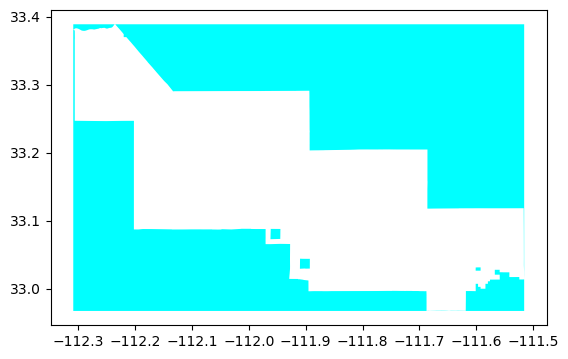

In [3]:
# Compute the area outside the Gila River Indian Community boundary
bbox = box(*boundary_gdf.total_bounds)
# Turn the bbox polygon into a GeoSeries (thanks ChatGPT)
gila_boundary_outside = gpd.GeoDataFrame(geometry=[bbox], crs=boundary_gdf.crs).overlay(boundary_gdf, how = "difference")
f, ax = plt.subplots()
gila_boundary_outside.plot(ax=ax, color="cyan")


Next, clip your DataArray to the boundaries for both inside and outside
the reservation. You will need to replace the `GeoDataFrame` name with
your own. Check out the [lesson on clipping data with the `rioxarray`
library in the
textbook](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/).

> **GOTCHA ALERT**
>
> It’s important to use `from_disk=True` when clipping large arrays like
> this. It allows the computer to use less valuable memory resources
> when clipping - you will probably find that otherwise the cell below
> crashes your kernel.

In [4]:
# Clip data to both inside and outside the boundary
# Inside
inside_clip = combined_ndvi_da.rio.clip(boundary_gdf.geometry, from_disk=True)
inside_clip

# Outside
outside_clip = combined_ndvi_da.rio.clip(gila_boundary_outside.geometry, from_disk=True)
outside_clip

<xarray.Dataset> Size: 48MB
Dimensions:      (x: 380, y: 203, date: 154)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB -112.3 -112.3 -112.3 ... -111.5 -111.5 -111.5
  * y            (y) float64 2kB 33.39 33.39 33.38 33.38 ... 32.97 32.97 32.97
  * date         (date) datetime64[ns] 1kB 2001-05-25 2001-06-10 ... 2022-08-29
    spatial_ref  int64 8B 0
Data variables:
    NDVI         (date, y, x) float32 48MB 0.6146 0.3796 ... 0.1736 0.2146

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>For <strong>both inside and outside</strong> the <span
data-__quarto_custom="true" data-__quarto_custom_type="Shortcode"
data-__quarto_custom_context="Inline"
data-__quarto_custom_id="3"></span> boundary:</p>
<ul>
<li>Group the data by year</li>
<li>Take the mean. You always need to tell reducing methods in
<code>xarray</code> what dimensions you want to reduce. When you want to
summarize data across <strong>all</strong> dimensions, you can use the
<code>...</code> syntax, e.g. <code>.mean(...)</code> as a
shorthand.</li>
<li>Select the NDVI variable</li>
<li>Convert to a DataFrame using the <code>to_dataframe()</code>
method</li>
<li>Join the two DataFrames for plotting using the <code>.join()</code>
method. You will need to rename the columns using the
<code>lsuffix=</code> and <code>rsuffix=</code> parameters</li>
</ul>
<p>Finally, plot annual July means for both inside and outside the
Reservation on the same plot.</p></div></div>

> **GOTCHA ALERT**
>
> The DateIndex in pandas is a little different from the Datetime
> Dimension in xarray. You will need to use the `.dt.year` syntax to
> access information about the year, not just `.year`.

In [5]:
# Compute mean annual July NDVI
# Inside
inside_means = (inside_clip # Select inside bounds
                .groupby(inside_clip.date.dt.year) #Group by the date time year
                .mean(...) # Take the mean accross all dimensions
                .NDVI # Select the NDVI variable
                .to_dataframe()) # Convert to dataframe

# Outside
outside_means = (outside_clip # Select inside bounds
                 .groupby(inside_clip.date.dt.year) #Group by the date time year
                 .mean(...) # Take the mean accross all dimensions
                 .NDVI # Select the NDVI variable
                 .to_dataframe())
# We select only the 'NDVI' column because that's all we care about
joined_df = inside_means[['NDVI']].join(outside_means[['NDVI']],
                                       lsuffix="_inside", # We have to set the suffixes because pandas won't do a join otherwise
                                       rsuffix="_outside")

joined_df

,NDVI_inside,NDVI_outside
year,,
2001,0.199645,0.247629
2002,0.177933,0.226726
2003,0.187302,0.229889
2004,0.176162,0.221753
2005,0.238630,0.255275
2006,0.211491,0.235571
2007,0.181710,0.211984
2008,0.201902,0.237739
2009,0.179118,0.218907


In [6]:
# Plot inside vs outside
joined_df.hvplot(title = "Mean NDVI inside and outside Gila River Indian Community")

:NdOverlay   [Variable]
   :Curve   [year]   (value)

Now, take the difference between outside and inside the site boundary
and plot that. What do you observe? Don’t forget to write a headline and
description of your plot!

In [7]:
# Compute the difference inside and outside the boundary
joined_df['difference'] = joined_df['NDVI_inside'] - joined_df['NDVI_outside']
joined_df

,NDVI_inside,NDVI_outside,difference
year,,,
2001,0.199645,0.247629,-0.047984
2002,0.177933,0.226726,-0.048793
2003,0.187302,0.229889,-0.042588
2004,0.176162,0.221753,-0.045591
2005,0.238630,0.255275,-0.016645
2006,0.211491,0.235571,-0.024079
2007,0.181710,0.211984,-0.030274
2008,0.201902,0.237739,-0.035836
2009,0.179118,0.218907,-0.039790


In [8]:
# Plot the difference
joined_df['difference'].hvplot(title="Difference in NDVI Inside vs. Outside the \n Gila River Indian Community")

:Curve   [year]   (difference)

Vegetation in Gila River Indian community recovers after the restoration of water rights. 

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [9]:
%store joined_df

Stored 'joined_df' (DataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!